## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Creando Coenxión con Mongo DB

In [3]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [4]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [5]:
# Registros
print(data_pandas.shape)

(870, 11)


In [6]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1950-01-01 00:00:00
2022-06-01 00:00:00


### Modelos NARX

Data para el modelo NAARX

In [7]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()
data_model['nino34_mean_exogena'] = data_model.nino34_mean

<AxesSubplot:xlabel='periodo'>

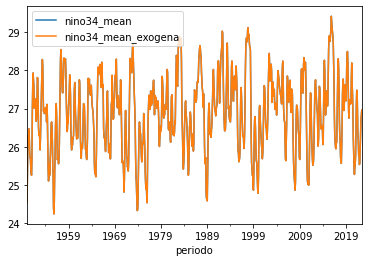

In [8]:
data_model.plot()

Definiendo variable de entrada y exógena

In [9]:
y_output = 'nino34_mean'
exogena = ['nino34_mean_exogena']

pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,nino34_mean,nino34_mean_exogena
periodo,,
1950-01-01,24.56,24.56
1950-02-01,25.07,25.07
1950-03-01,25.88,25.88
1950-04-01,26.29,26.29
1950-05-01,26.19,26.19
1950-06-01,26.47,26.47
1950-07-01,26.28,26.28
1950-08-01,25.88,25.88
1950-09-01,25.73,25.73


Normalización de los datos

In [10]:
# t_exogena = ['t_' + x for x in exogena]
# t_output = 't_' + y_output


# data_mean = pd_model.mean()
# data_std = pd_model.std()

# pd_model[t_output] = (pd_model[y_output] - data_mean[data_mean.index==y_output][0])/data_std[data_std.index==y_output][0]

# for x in exogena:
#     pd_model['t_' + x] = (pd_model[x] - data_mean[data_mean.index==x][0])/data_std[data_std.index==x][0]

In [11]:
# data_modelo = pd_model[[t_output]+t_exogena]
# data_modelo.head(10)

Parámetros de del modelo NARX 

In [12]:
prediction_order = 12 # rango de prediccion
auto_order = 12 # componente autoregresiva
exog_order = 36 # componente exogena qm
exog_delay = 1 # componente exogena dm

In [13]:
def date_window(pd_model,auto_order,exog_order,exog_delay,exogena,output):
    """
    Funcion para estructurar los datos de entrada del modelo NARX
    """

    X = pd_model[exogena].to_numpy().astype(float)
    y = pd_model[[output]].to_numpy().astype(float)

    # Data para el mmodelo
    input_data = []
    output_data = []
    for t in range(max(auto_order, exog_order), len(y)):
        input_data.append(np.concatenate((y[(t - auto_order + 1):(t + 1)], X[(t - exog_delay - exog_order + 1):(t - exog_delay + 1)]), axis=0) )
        output_data.append(np.array(y[t]))

    # Input del modelo
    input_data = np.array(input_data)
    # Output del modelo
    output_data = np.array(output_data)

    return (input_data.reshape(input_data.shape[0],input_data.shape[1]), output_data)

In [14]:
# Data Test
data_test = pd_model[:-prediction_order]
input_data, output_data = date_window(pd_model=data_test,
                                        auto_order=auto_order,
                                        exog_order=exog_order,
                                        exog_delay=exog_delay,
                                        exogena=exogena,
                                        output=y_output)

print(input_data.shape)
print(output_data.shape)

(822, 48)
(822, 1)


In [15]:
pd_model[:-prediction_order]

,nino34_mean,nino34_mean_exogena
periodo,,
1950-01-01,24.56,24.56
1950-02-01,25.07,25.07
1950-03-01,25.88,25.88
1950-04-01,26.29,26.29
1950-05-01,26.19,26.19
...,...,...
2021-02-01,25.76,25.76
2021-03-01,26.50,26.50
2021-04-01,27.11,27.11


In [16]:
# Neuronas capa entrada
_ , ninp = input_data.shape

# Capas de la red
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden2)
output = keras.layers.Dense(1)(hidden3)

# Definiendo red 
model = keras.models.Model(inputs=[input_],outputs=[output])

# Definiendo optimizador y learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# Compilando el modelo a entrenar
model.compile(loss="mean_squared_error", optimizer=optimizer)

2022-08-10 04:42:15.571118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Parametros de entrenamiento
epochs = 1000
batch_size = 32
validation_split = 0.30

path_checkpoint = "./model_checkpoint/narx_sst_nino34.h5"

patience = 10
min_delta = 0

# Entrenando la red
es_callback = keras.callbacks\
                    .EarlyStopping(monitor="val_loss",
                                   min_delta=min_delta,
                                   patience=patience,
                                   mode='min')

modelckpt_callback = keras.callbacks\
                            .ModelCheckpoint(
                                    monitor="val_loss",
                                    filepath=path_checkpoint,
                                    verbose=0,
                                    save_weights_only=True,
                                    save_best_only=True)

history = model.fit(
                x=input_data,
                y=output_data,
                epochs=epochs,
                verbose=0,
                validation_split=validation_split,
                callbacks=[es_callback, modelckpt_callback])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense (Dense)               (None, 48)                2352      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


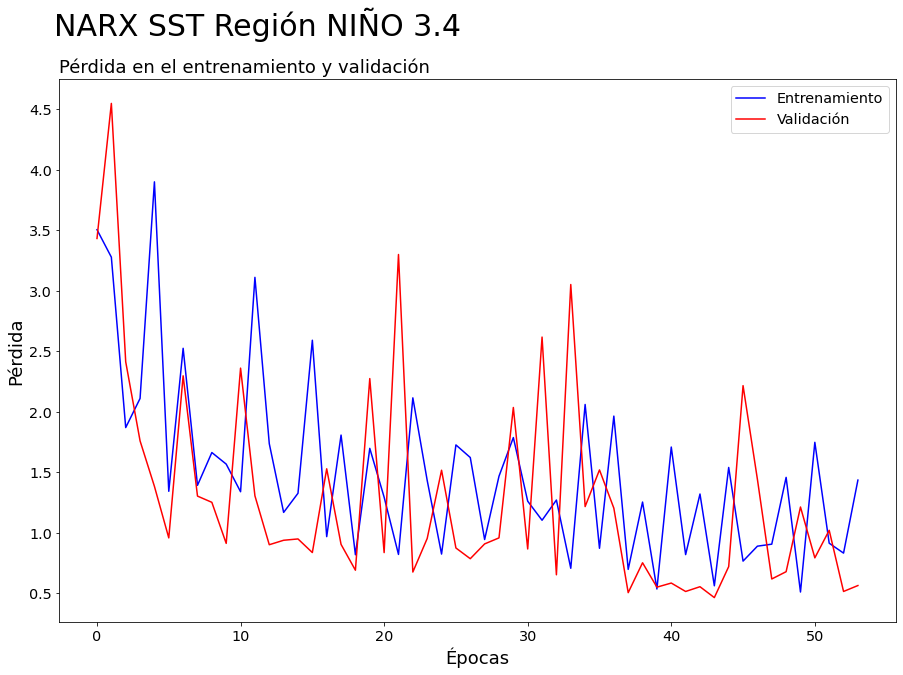

In [18]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

def visualizar_perdida(history, title):
    """
    Funcion para visualizar la funcion de perdida de la red NARX
    """
    params = {'legend.fontsize': 'x-large',
            #'figure.figsize': (15, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(15,10))
    pylab.rcParams.update(params)
    plt.plot(epochs, loss, "b", label="Entrenamiento")
    plt.plot(epochs, val_loss, "r", label="Validación")
    
    plt.title('Pérdida en el entrenamiento y validación',loc='left',fontsize=18)
    plt.suptitle(title,ha='left',fontsize=30,x=0.12)
    plt.xlabel("Épocas",fontsize=18)
    plt.ylabel("Pérdida",fontsize=18)
    plt.legend()
    plt.show()

visualizar_perdida(history, "NARX SST Región NIÑO 3.4")

# Validación del modelo

Datos para validación

In [19]:
prediction_test = model.predict(input_data,
                                batch_size=batch_size,
                                verbose=0,
                                steps=None,
                                callbacks=None,
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False)

In [20]:
pd_validation = pd_model.copy().reset_index(drop=False)
pd_validation['prediction'] = np.nan
pd_validation['type'] = 'training'
pd_validation.loc[ data_test.shape[0]: , 'type' ] = 'validation'

# Prediccion training
pd_validation.loc[ range(max(auto_order, exog_order),(data_test.shape[0])), 'prediction' ] = prediction_test

pd_validation.head()

,periodo,nino34_mean,nino34_mean_exogena,prediction,type
0,1950-01-01,24.56,24.56,NaN,training
1,1950-02-01,25.07,25.07,NaN,training
2,1950-03-01,25.88,25.88,NaN,training
3,1950-04-01,26.29,26.29,NaN,training
4,1950-05-01,26.19,26.19,NaN,training


<AxesSubplot:>

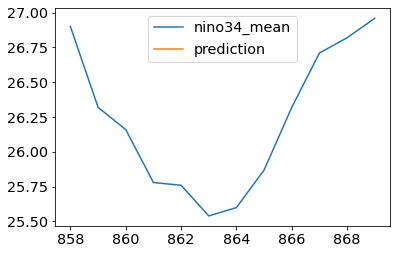

In [21]:
pd_validation[pd_validation.type=='validation'][['nino34_mean','prediction']].plot()

In [22]:
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)

In [23]:
data_pandas.index 

DatetimeIndex(['2022-06-01', '2022-05-01', '2022-04-01', '2022-03-01',
               '2022-02-01', '2022-01-01', '2021-12-01', '2021-11-01',
               '2021-10-01', '2021-09-01',
               ...
               '1950-10-01', '1950-09-01', '1950-08-01', '1950-07-01',
               '1950-06-01', '1950-05-01', '1950-04-01', '1950-03-01',
               '1950-02-01', '1950-01-01'],
              dtype='datetime64[ns]', name='periodo', length=870, freq=None)

In [24]:
data_test.index.max().strftime('%Y-%m')

'2021-06'

In [25]:
data_test.index.max()  + pd.DateOffset(months=1)

Timestamp('2021-07-01 00:00:00')

In [26]:
def forecast_one_step(data,model,auto_order,exog_order,exog_delay,exogena,y_output,batch_size):
    """
    Funcion para la prediccion a one step
    """

    # Pandas Data Frame
    pd_update = pd.DataFrame()
    # Agregando Index 
    pd_update['periodo'] = pd.to_datetime([ (data.index.max() + pd.DateOffset(months=1) ).strftime('%Y-%m')])
    pd_update = pd_update.set_index('periodo')
    #print(pd_update.index )
    pd_update[y_output] = np.nan
    for col in exogena:
        pd_update[col] = np.nan

    pd_update['type'] = 'self_prediction'

    # Formato a los datos
    input_data_validate, _ = date_window(pd_model=data.copy(),
                                        auto_order=auto_order,
                                        exog_order=exog_order,
                                        exog_delay=exog_delay,
                                        exogena=exogena,
                                        output=y_output)

    # Data para pronostico
    past_row = input_data_validate[-1].reshape(1, input_data_validate.shape[1])

    # prediccion
    prediction_validation = model.predict(  past_row,
                                            batch_size=batch_size,
                                            verbose=0,
                                            steps=None,
                                            callbacks=None,
                                            max_queue_size=10,
                                            workers=1,
                                            use_multiprocessing=False)

    pd_update[y_output] = prediction_validation.flat[0]

    return pd_update

In [27]:
# Generando auto predicion
pd_selfPrediction = data_test.copy()
pd_selfPrediction['type'] = 'historical'

for x in range(prediction_order):
    selfPrediction = forecast_one_step( data=pd_selfPrediction.copy(),
                                        model=model,
                                        auto_order=auto_order,
                                        exog_order=exog_order,
                                        exog_delay=exog_delay,
                                        exogena=exogena,
                                        y_output=y_output,
                                        batch_size=batch_size)

    selfPrediction[exogena] = selfPrediction[y_output]

    pd_selfPrediction = pd.concat([pd_selfPrediction, selfPrediction]).copy()  

pd_selfPrediction

,nino34_mean,nino34_mean_exogena,type
periodo,,,
1950-01-01,24.560000,24.560000,historical
1950-02-01,25.070000,25.070000,historical
1950-03-01,25.880000,25.880000,historical
1950-04-01,26.290000,26.290000,historical
1950-05-01,26.190000,26.190000,historical
...,...,...,...
2022-02-01,27.344965,27.344965,self_prediction
2022-03-01,27.450668,27.450668,self_prediction
2022-04-01,27.525352,27.525352,self_prediction


In [41]:
pd_selfPrediction[-prediction_order:][y_output].to_numpy()

array([27.41222382, 27.4008522 , 27.28521729, 27.2396698 , 27.19079208,
       27.08088112, 27.1448307 , 27.34496498, 27.45066833, 27.52535248,
       27.62236595, 27.67429352])

In [42]:
pd_validation.loc[ data_test.shape[0]: , 'prediction' ] = pd_selfPrediction[-prediction_order:][y_output].to_numpy()

In [43]:
pd_validation[data_test.shape[0]-1: ]

,periodo,nino34_mean,nino34_mean_exogena,prediction,type
857,2021-06-01,27.45,27.45,27.412224,training
858,2021-07-01,26.90,26.90,27.412224,validation
859,2021-08-01,26.32,26.32,27.400852,validation
860,2021-09-01,26.16,26.16,27.285217,validation
861,2021-10-01,25.78,25.78,27.239670,validation
862,2021-11-01,25.76,25.76,27.190792,validation
863,2021-12-01,25.54,25.54,27.080881,validation
864,2022-01-01,25.60,25.60,27.144831,validation
865,2022-02-01,25.87,25.87,27.344965,validation
866,2022-03-01,26.32,26.32,27.450668,validation


In [28]:
pd_test = pd.DataFrame()

pd_test['real'] = pd_model[-prediction_order:][y_output]
pd_test['prediccion'] = pd_selfPrediction[-prediction_order:][y_output]

<AxesSubplot:xlabel='periodo'>

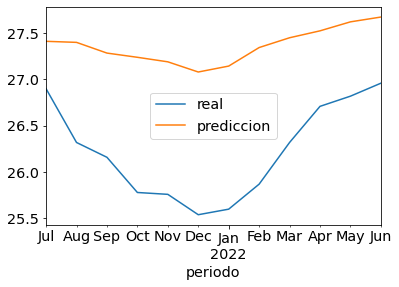

In [29]:
pd_test.plot()

In [30]:
pd_test['residuos'] = pd_test.real-pd_test.prediccion

In [31]:
pd_test.mean()

real          26.228333
prediccion    27.364343
residuos      -1.136009
dtype: float64